# Mushroom Classification

Hi! Thanks for checking this notebook. 

Aside from applying some ML techniques to classify if a mushroom is edible or poisonous, we'll try to determine the most important features for this decision. 

Finally, the interpretation of the most relevant features is briefly explained using the odds ratio computed from the logistic regression algorithm.

In [1]:
import dython.nominal as dm
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

plt.style.use('seaborn')
pd.set_option("display.max_rows", 100)

In [3]:
data = pd.read_csv("../input/mushrooms.csv")

# Exploratory Analysis

In [4]:
data.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [5]:
data.describe()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,...,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,...,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,...,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,...,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


With this initial overview of the data its possible to conclude that:

1. All variables are categorical
2. The response variable "class" presents only two categories (edible and poisonous) making this a binary classification problem
3. The  data seems to be evenly balanced between the two categories we are trying to predict
4. "veil-type" only has one category so it does not provide any useful information for the classification procedure


In [6]:
data = data.drop(['veil-type'], axis=1)

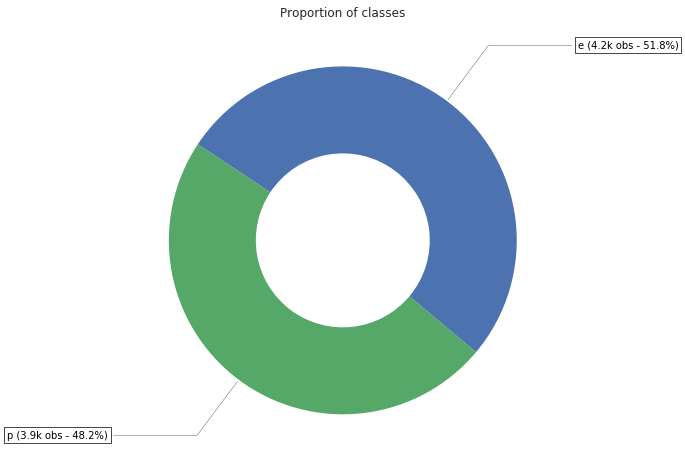

In [7]:
def donut_chart(data):
    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw=dict(aspect="equal"))

    recipe = list(data.value_counts().index)

    info = data.value_counts()

    def pcts(val_list):
        pct = []
        for val in val_list:
            pct.append(" ({:.1f}k obs - {:.1f}%)".format(val/1000, 100*val/np.sum(val_list)))
        return pct

    recipe2 = pcts(info)

    wedges, texts = ax.pie(info, wedgeprops=dict(width=0.5), startangle=-40)

    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),
              bbox=bbox_props, zorder=0, va="center")

    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = f"angle,angleA=0,angleB={ang}"
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        kw["color"] = 'k'
        ax.annotate(recipe[i]+recipe2[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                     horizontalalignment=horizontalalignment, **kw)

    ax.set_title("Proportion of classes")
    plt.show()
    
donut_chart(data['class'])

In [8]:
data.isnull().sum()

class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64

The two classes are indeed evenly distributed across the dataset.

The data doesn't exhibit missing values and since all the variables are categorical there is no need to take outliers into consideration. Really easy dataset to work with, cheers to the people involved in its creation!

We desire to see what are the most important features for the classification problem at hand and to visually explore the data. However, correlation is of no use in this scenario and there is no numerical info to plot. 

With this in mind, the following plots are constructed for each feature: 

1. The crosstab count between the feature and the class (upper center)
    1.1 The value of Cramer's V for the feature and the class
2. The proportion of features across classes (lower left)
    2.1 The value of Theils' U for the feature given the class
3. The proportion of classes across features (lower right)
    3.1 The value of Theils' U for the class given the feature

**A couple of notes:
- Cramer's V is symmetrical
- Theils' U is not symmetrical
- The proportion of features across classes is an estimate of the conditional probability of having a feature given a class P(feature|class)
- The latter is also true for the other way around
**

In [9]:
def generate_freq_heatmaps(feature):
    wild_ct = pd.crosstab(data[feature], 
                          data['class'])

    wild_ct_pct = wild_ct.apply(lambda r: r/r.sum(), axis=0)
    wild_ct_pct2 = wild_ct.apply(lambda r: r/r.sum(), axis=1)
    
    cram_v = dm.cramers_v(data[feature], data['class'])
    t_u_given_class = dm.theils_u(data[feature], data['class'])
    t_u_given_feature = dm.theils_u(data['class'], data[feature])
    
    plt.figure(figsize=(12,10))

    ax1 = plt.subplot2grid((3,2), (0, 0), colspan=2, 
                title=f"Overall Count of {feature} \n Cramer's V: {cram_v:.3f}")
    ax2 = plt.subplot2grid((3,2), (1, 0), 
                title=f"P({feature}|class) \n Theil's U: {t_u_given_class:.3f}")
    ax3 = plt.subplot2grid((3,2), (1, 1), 
                title=f"P(class|{feature}) \n Theil's U: {t_u_given_feature:.3f}")

    sns.heatmap(wild_ct, cmap=sns.color_palette("BuGn"), annot=True, fmt='g', ax=ax1)
    sns.heatmap(wild_ct_pct, cmap=sns.color_palette("GnBu"), annot=True, fmt='.0%', ax=ax2)
    sns.heatmap(wild_ct_pct2, cmap=sns.color_palette("GnBu"), annot=True, fmt='.0%', ax=ax3)

    plt.tight_layout()
    plt.show()

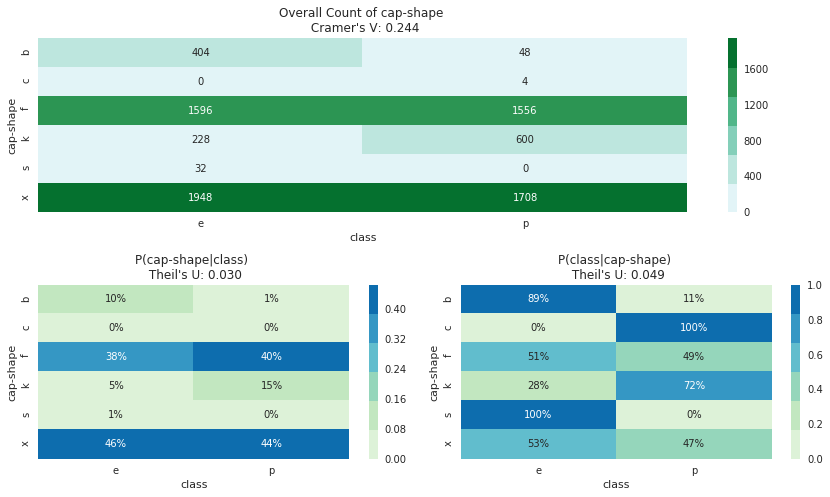

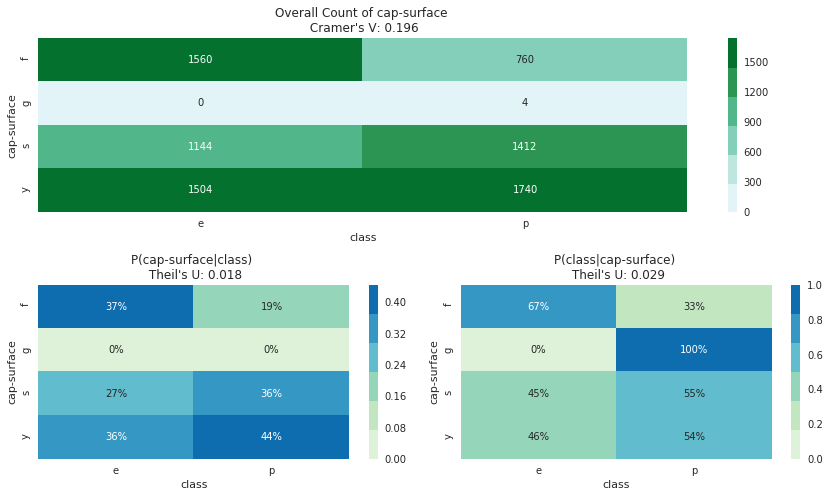

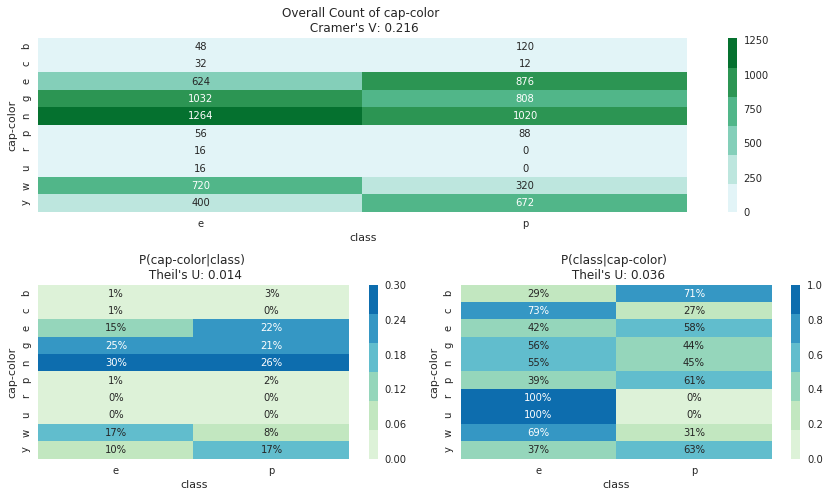

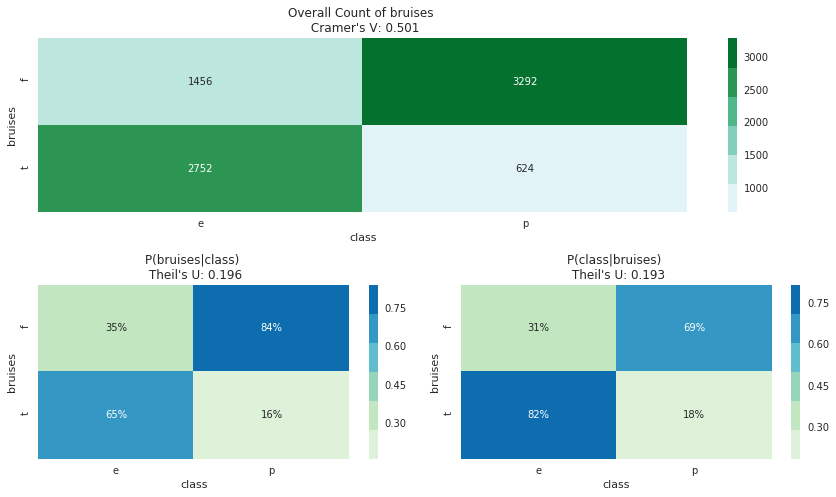

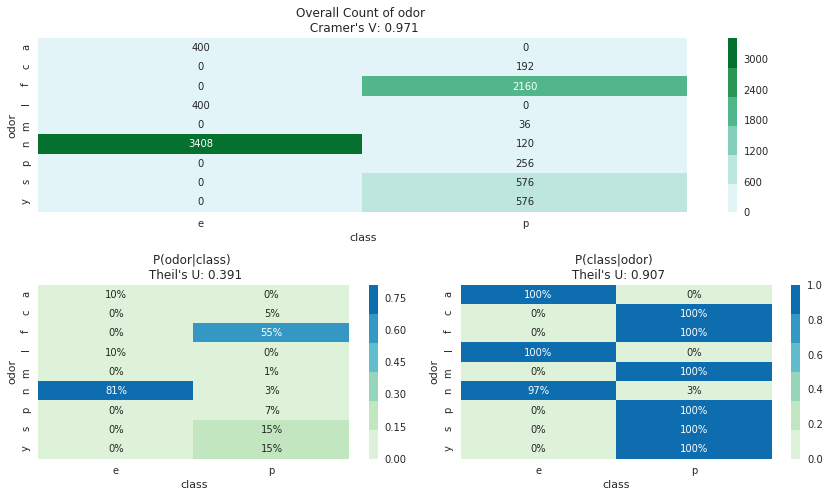

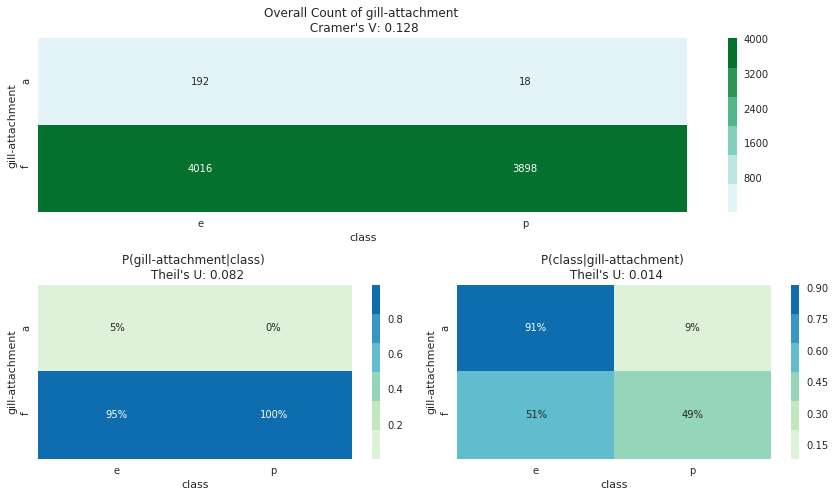

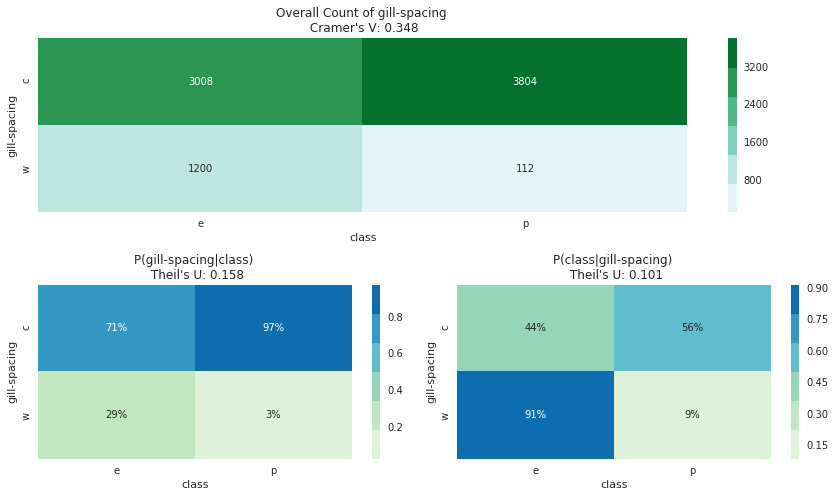

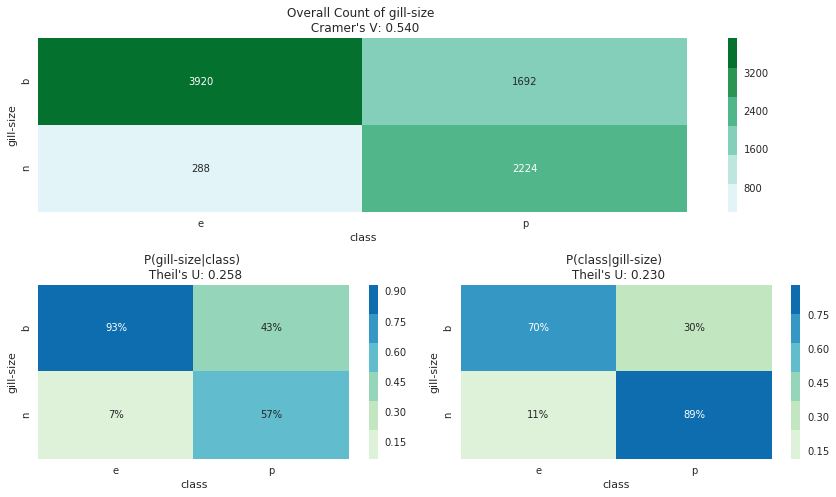

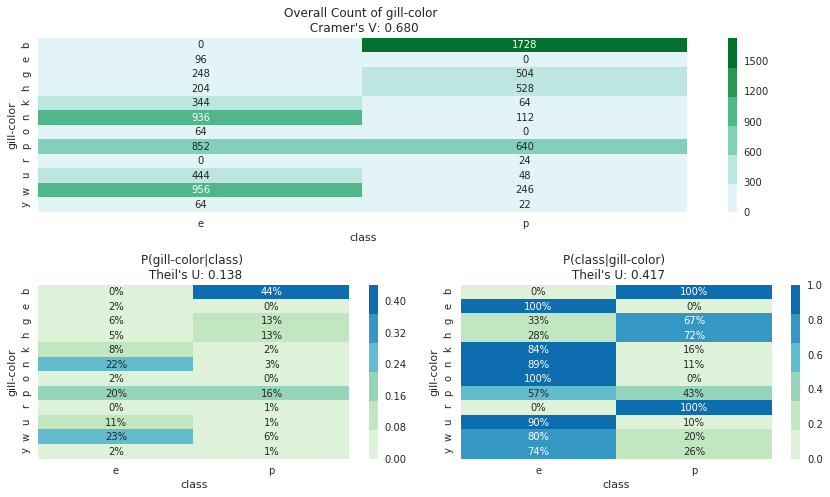

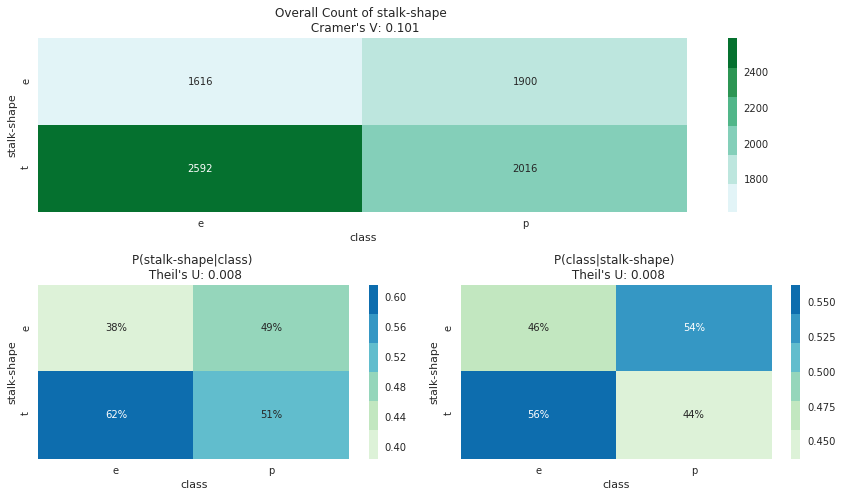

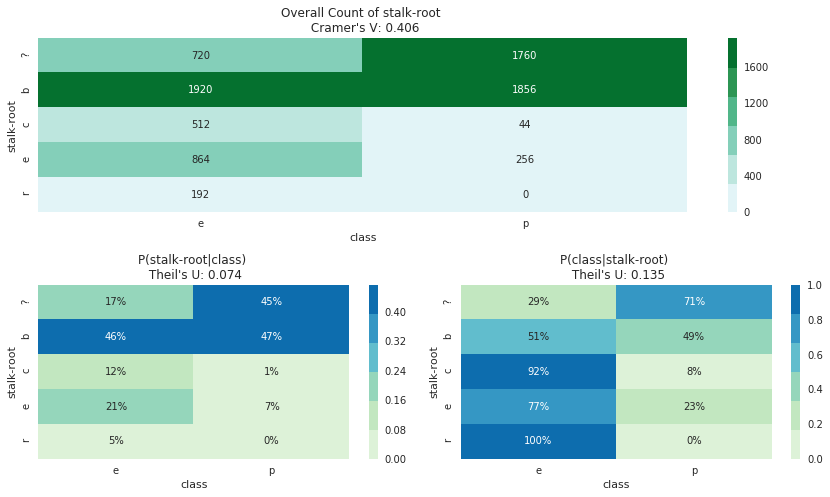

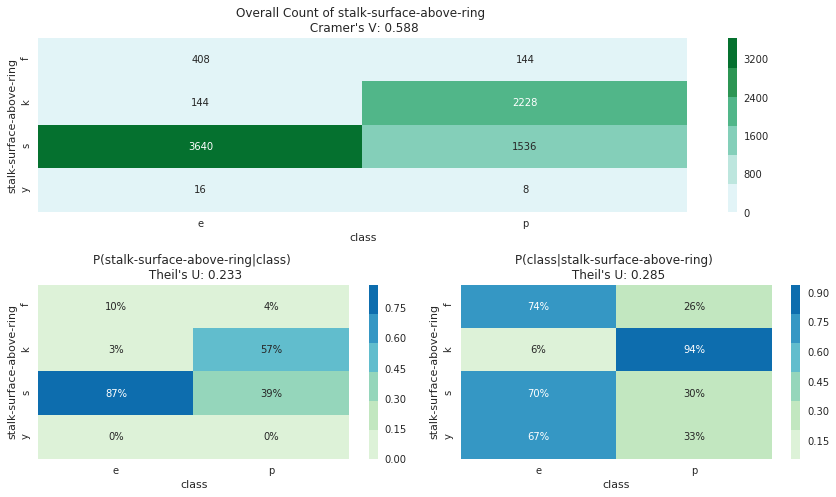

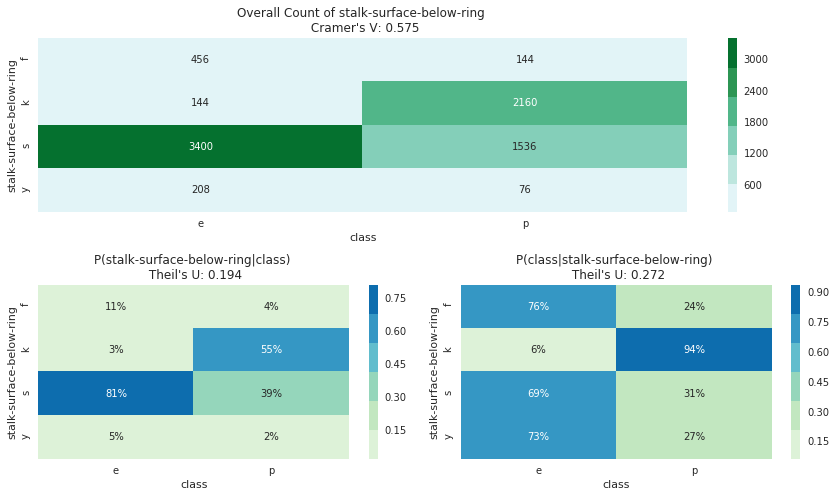

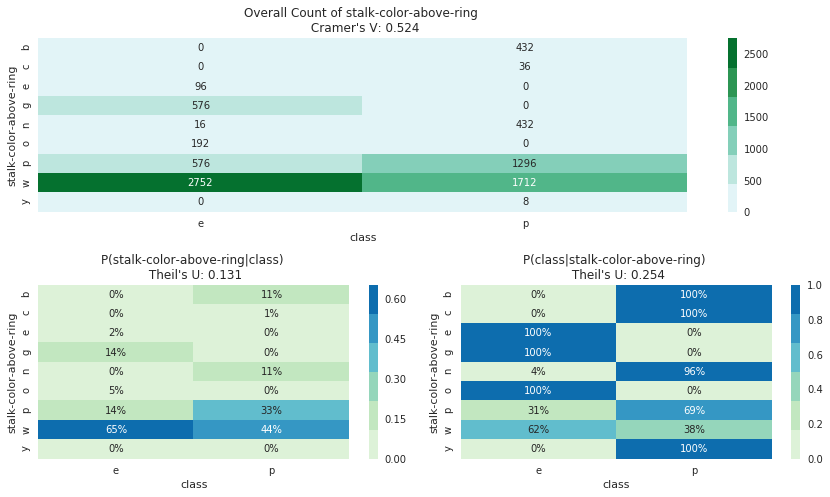

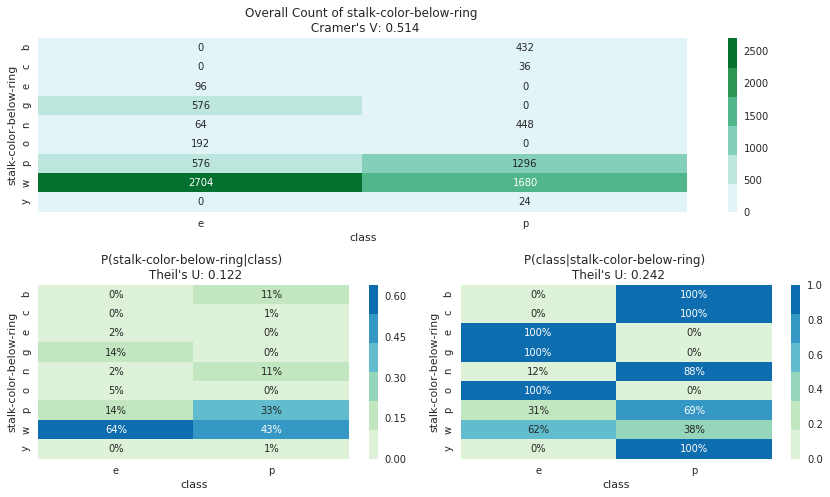

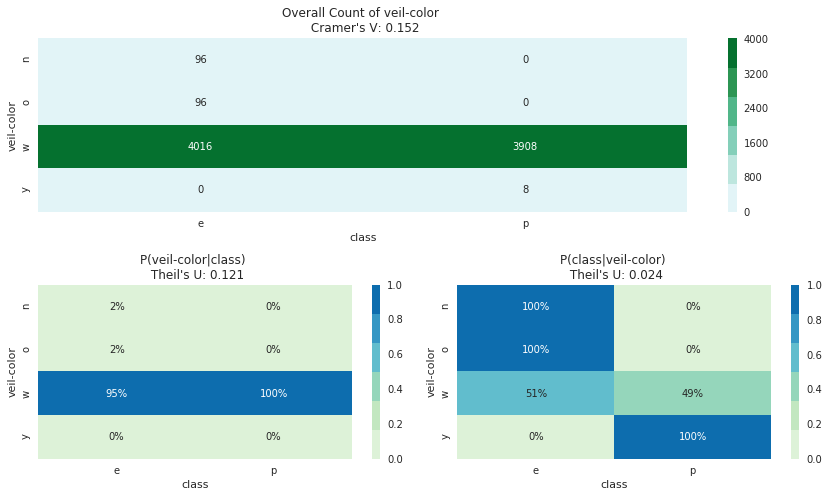

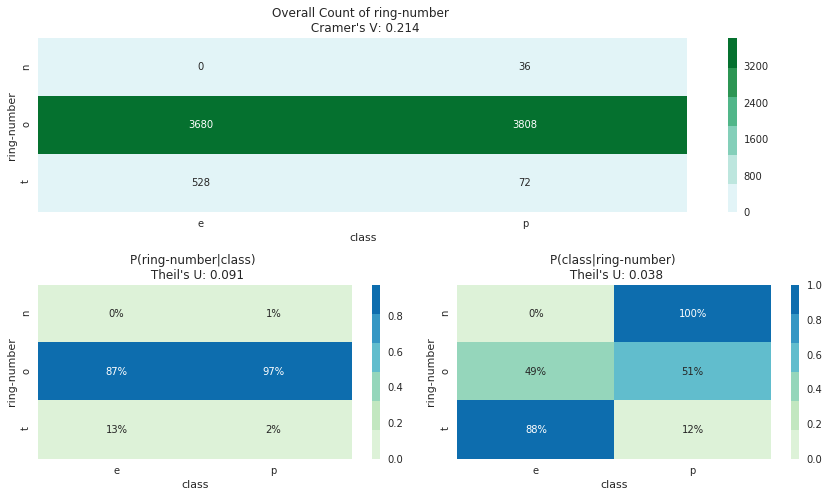

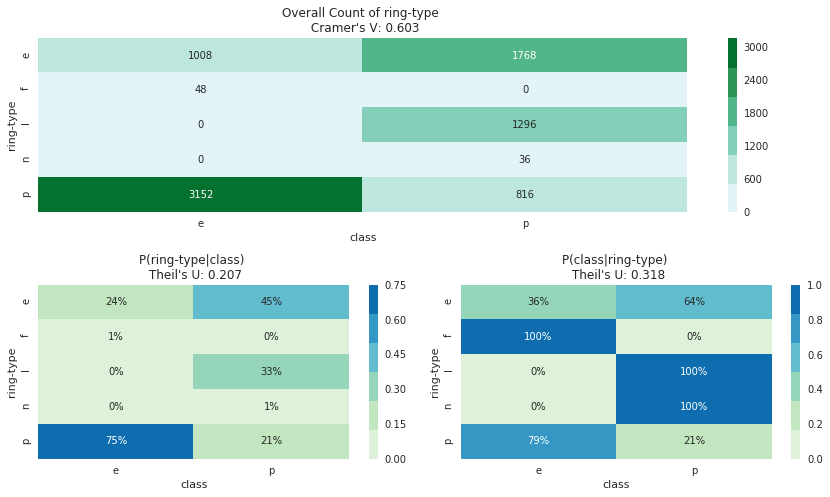

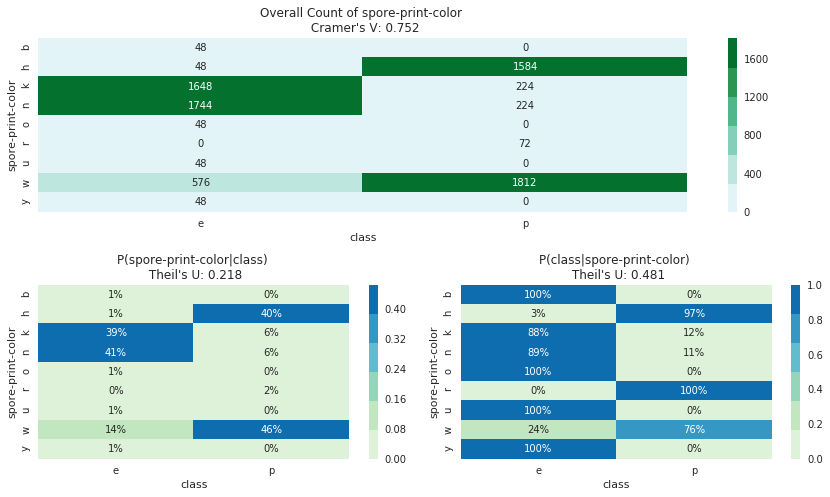

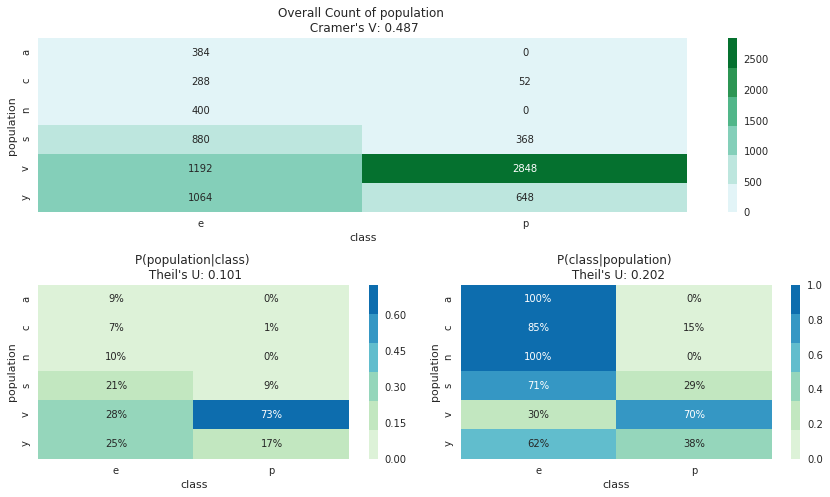

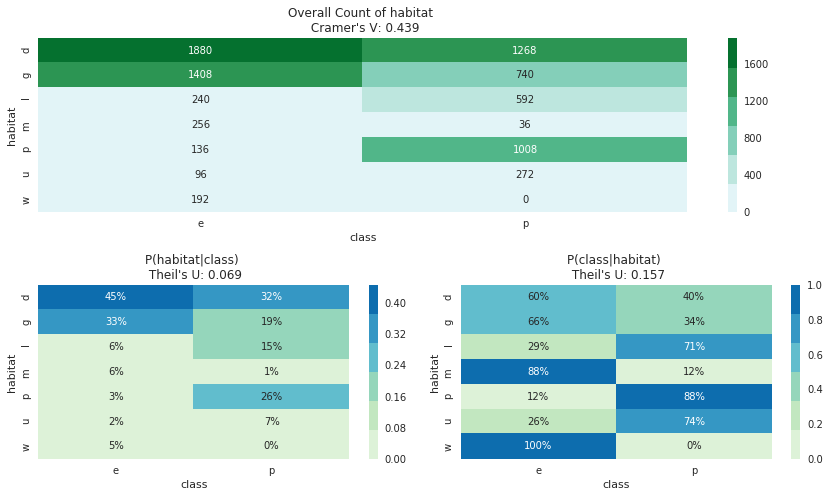

In [10]:
features = [col for col in data.columns if col != 'class']

for feature in features:
    generate_freq_heatmaps(feature)

That was a lot of info to visualize.

Let's compact the results to determine the most relevant features.

Ordered plots for Cramer's V and Theil's U (for the class given the feature) are present below:

**
Note: only one value for Theil's U is considered, concretely the one that takes into account the class given the feature because that is the way our model will work, a prediction of a class given a feature.
**

In [11]:
def get_nominal_scores(func):
    scores = pd.DataFrame(features, columns=['feature'])
    scores['score'] = scores['feature'].apply(lambda x: func(data['class'], data[x]))
    scores = scores.sort_values(by='score', ascending=False)
    return scores

In [12]:
cramers_vs = get_nominal_scores(dm.cramers_v)
theils_us = get_nominal_scores(dm.theils_u)

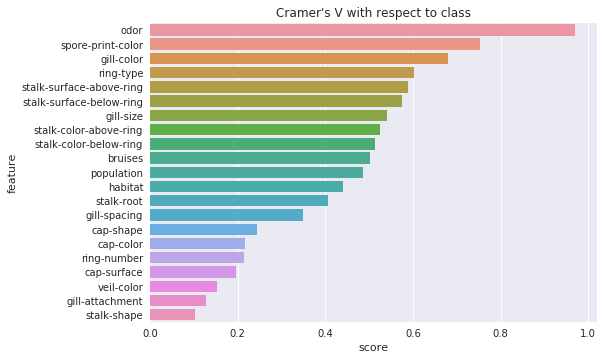

In [13]:
ax = sns.barplot(x="score", y="feature", data=cramers_vs)
ax.set_title("Cramer's V with respect to class")
plt.show()

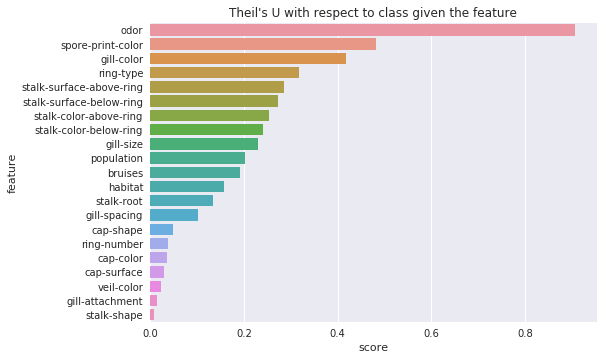

In [14]:
ax = sns.barplot(x="score", y="feature", data=theils_us)
ax.set_title("Theil's U with respect to class given the feature")
plt.show()

Both metrics agree on the 9 most important features (although in slighlty different order), which are:

- odor
- spore-print-color
- gill-color
- ring-type
- stalk-surface-above-ring
- stalk-surface-below-ring
- gill-size
- stalk-color-above-ring
- stalk-color-below-ring

# Classification using some ML algorithms

Now that we have done an exploratory analysis on the data let's switch to our other goal. To predict if an mushroom is edible or not. 

For this, several classification algorithms are applied to the data and compared using common classification metrics.

First we'll shuffle the data and convert every categorical variable to a dummy variable:

In [15]:
data = data.reindex(np.random.permutation(data.index))
data = pd.get_dummies(data, drop_first=True)
data.head()

,class_p,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_g,cap-surface_s,cap-surface_y,cap-color_c,...,population_n,population_s,population_v,population_y,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
1539,0,0,1,0,0,0,0,1,0,0,...,0,1,0,0,1,0,0,0,0,0
265,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
875,0,0,0,0,0,1,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0
1238,0,0,0,0,0,1,0,1,0,0,...,0,1,0,0,1,0,0,0,0,0
7624,1,0,0,1,0,0,0,1,0,0,...,0,0,1,0,0,1,0,0,0,0


After converting all variables to dummies, the response variable is 1 if mushroom is poisonous and 0 if not. 

In this case it is considered a "positive" response if the mushroom is indeed poisonous.

Now let's separate the response variable from the predictors:

In [16]:
y = data.iloc[:,0:1]
X = data.iloc[:,1:]

In this setting we prefer False Positives over False Negatives. 

This is because classifying an edible mushroom as poisonous and not eating it is far less dangerous than the other way around. For this reason **recall is more important than precision** 

With the help of cross validation, let's define a function that will help us compare the ML algorithms:

In [17]:
from sklearn.model_selection import cross_validate

def eval_model(model):
    cv_results = cross_validate(model, X, y.values.ravel(), cv=5, scoring=('roc_auc', 
                                                                           'precision',
                                                                           'recall',
                                                                           'f1'))
    
    print("=== Mean Test Results for {} ===".format(type(model).__name__))
    print("RECALL: {:.3f}".format(cv_results.get('test_recall').mean()))
    print("ROC AUC: {:.3f}".format(cv_results.get('test_roc_auc').mean()))
    print("PRECISION: {:.3f}".format(cv_results.get('test_precision').mean()))
    print("F1 SCORE: {:.3f} \n".format(cv_results.get('test_f1').mean()))


One of the algorithms used is a support vector classifier, which needs some hyperparameter tuning. Let's do that real quick:

In [18]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(X, y.values.ravel(), test_size=0.1, random_state=0)

tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

clf = GridSearchCV(SVC(), tuned_parameters, cv=5, scoring='recall')
clf.fit(X_train, y_train)

means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

0.975 (+/-0.011) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.799 (+/-0.030) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.992 (+/-0.002) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.975 (+/-0.011) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
1.000 (+/-0.000) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.992 (+/-0.002) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
1.000 (+/-0.000) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
1.000 (+/-0.000) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
1.000 (+/-0.000) for {'C': 1, 'kernel': 'linear'}
1.000 (+/-0.000) for {'C': 10, 'kernel': 'linear'}
1.000 (+/-0.000) for {'C': 100, 'kernel': 'linear'}
1.000 (+/-0.000) for {'C': 1000, 'kernel': 'linear'}


The reason why we did a train test split is to have a separate split of the data in which we can test the selected hyperparameters. If all of the data was used, we would have leaked info and that should be avoided.

Seems that the best kernel is linear with no need to tweak the penalization parameter. Let's test it in the test split:

In [19]:
from sklearn.metrics import classification_report

svc_tuning = SVC(kernel="linear", C=1)
svc_tuning.fit(X_train, y_train)
svc_tuning_preds = svc_tuning.predict(X_test)

print(classification_report(y_test, svc_tuning_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       414
           1       1.00      1.00      1.00       399

   micro avg       1.00      1.00      1.00       813
   macro avg       1.00      1.00      1.00       813
weighted avg       1.00      1.00      1.00       813



Now that SVC is tuned, let's compare different ML models for this task:

In [20]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
 
gnb = GaussianNB()
logit = LogisticRegression(solver='liblinear')
svc = SVC(kernel="linear", C=1)
knn = KNeighborsClassifier(3)
xgb = XGBClassifier()

classifiers = [gnb, logit, svc, xgb]

for classifier in classifiers:
    eval_model(classifier)

=== Mean Test Results for GaussianNB ===
RECALL: 0.999
ROC AUC: 0.997
PRECISION: 0.898
F1 SCORE: 0.946 

=== Mean Test Results for LogisticRegression ===
RECALL: 0.999
ROC AUC: 1.000
PRECISION: 1.000
F1 SCORE: 0.999 

=== Mean Test Results for SVC ===
RECALL: 1.000
ROC AUC: 1.000
PRECISION: 1.000
F1 SCORE: 1.000 

=== Mean Test Results for XGBClassifier ===
RECALL: 1.000
ROC AUC: 1.000
PRECISION: 1.000
F1 SCORE: 1.000 



XGBoost, SVC and Logit perform really well, with the two first being able to perfectly classify if a mushroom is edible or not across the different folds of CV. 

# Feature Interpretation

Logit is not perfect but since it's recall is almost 1 and it is the model that provides easier interpretation, we will use the Odds Ratios computed from it to interpret our features. 

Let's remember that the coefficients of the logit regression can be used to calculate the Odds Ratio of each variable. In this case the Odds Ratio is calculated against the base (the dummy variable that was left out) and this happens to all features since they all are categorical.

Let's train the logit model on the X_train defined when tuning the SVC to get the beta coefficients:

In [21]:
logit.fit(X_train, y_train)
logit_pred = logit.predict(X_test)
print(classification_report(y_test, logit_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       414
           1       1.00      1.00      1.00       399

   micro avg       1.00      1.00      1.00       813
   macro avg       1.00      1.00      1.00       813
weighted avg       1.00      1.00      1.00       813



The Odds Ratio is equal to the natural exponentiation of the regression coefficients (betas). 

Let's create a DataFrame containing this info for all dummy variables including the bases for each feature (which were previously dropped):

In [22]:
df_log = pd.DataFrame({'feature': np.array(X.columns), 'beta':logit.coef_[0]})
df_log['OR'] = np.exp(df_log['beta'])

bases = ['class_e', 'cap-shape_b', 'cap-surface_f', 'cap-color_b', 'bruises_f', 'odor_a',
 'gill-attachment_a', 'gill-spacing_c', 'gill-size_b', 'gill-color_b', 'stalk-root_?',
 'stalk-color-above-ring_b', 'stalk-color-below-ring_b', 'veil-color_n',
 'ring-number_n', 'ring-type_e', 'spore-print-color_b', 'population_a', 'habitat_d',
'stalk-shape_e', 'stalk-surface-above-ring_f', 'stalk-surface-below-ring_f'] 

pd_bases = pd.DataFrame.from_dict({
    'feature': bases,
    'beta': np.zeros(len(bases)),
    'OR': np.ones(len(bases))
})

df_log = pd.concat([df_log, pd_bases])
df_log

,feature,beta,OR
0,cap-shape_c,0.568158,1.765013
1,cap-shape_f,-0.221263,0.801506
2,cap-shape_k,-0.146507,0.863720
3,cap-shape_s,-0.660006,0.516848
4,cap-shape_x,-0.357894,0.699147
5,cap-surface_g,1.066294,2.904596
6,cap-surface_s,0.631177,1.879821
7,cap-surface_y,0.495787,1.641790
8,cap-color_c,-1.083437,0.338430
9,cap-color_e,0.133677,1.143023


It is important to notice that a bigger OR corresponds to a bigger magnitude of the odds of having a "success". In this case this represents the chances of the mushroom being poisonous. 

**So a bigger OR is an indication of danger.**

In general, if an OR is greater to 1 the corresponding beta will be positive and this indicates that the category denotes a greater probability of a mushroom being poisonous when compared to the base category. 

On the other hand, an OR lower than 1 will correspond to a negative beta and this indicates that the category denotes a smaller probability of a mushroom being poisonous when compared to the base category.

Let's plot the betas (the plot is cooler since it shows which categories are more and less dangerous) for each category of each feature along with the bases:

In [23]:
def graph_ors(feature):
    ors = df_log[df_log['feature'].str.contains(feature)]
    ors = ors.sort_values(by='OR', ascending=False)

    ax = sns.barplot(x="beta", y="feature", data=ors)
    ax.set_title(f"Log of Odds Ratio for {feature}")
    plt.show()

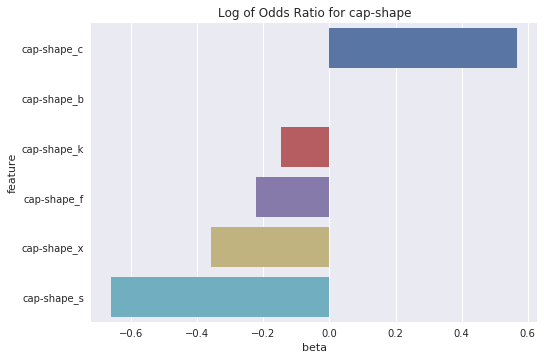

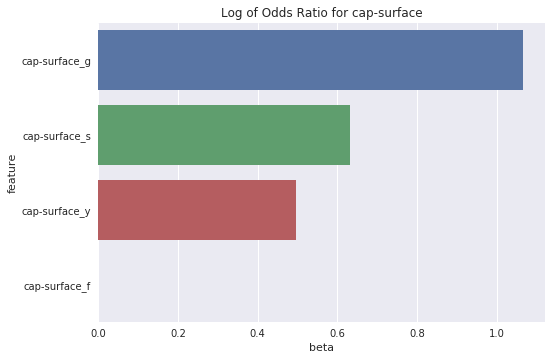

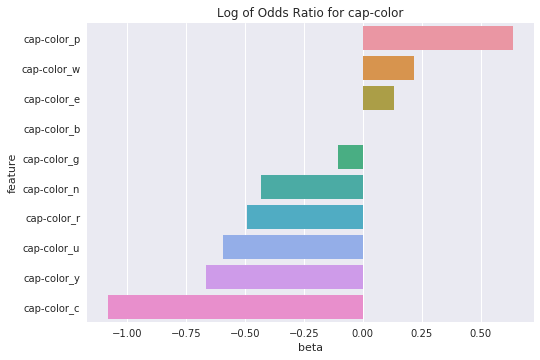

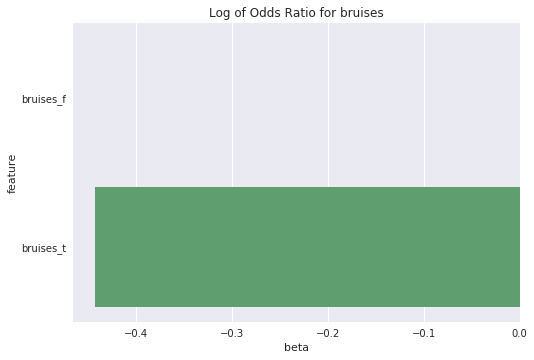

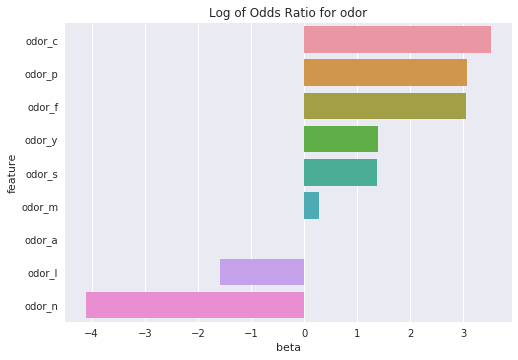

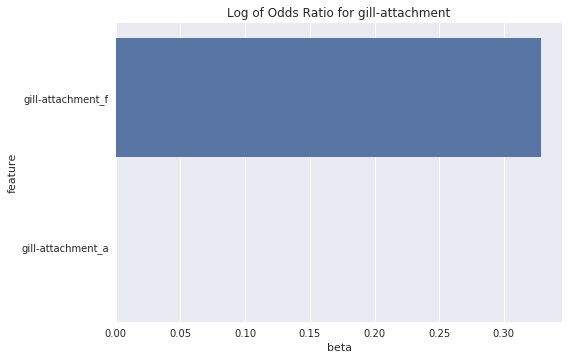

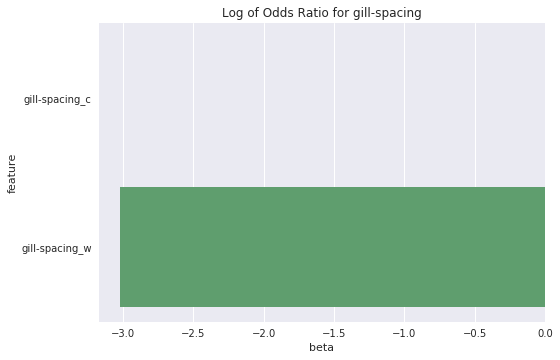

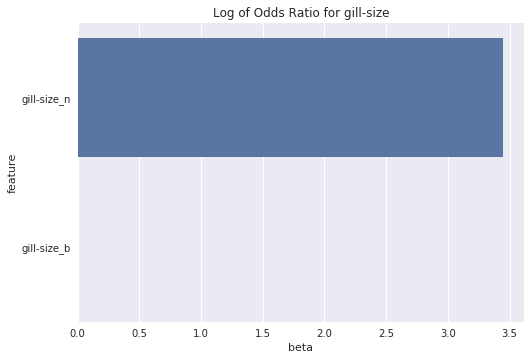

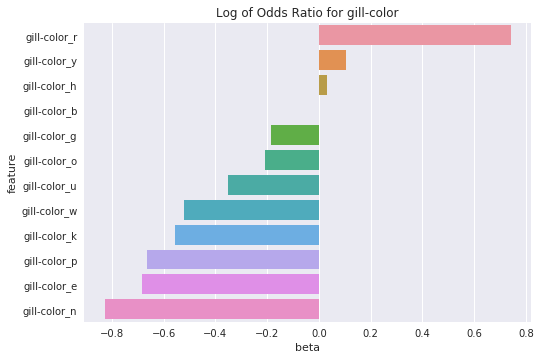

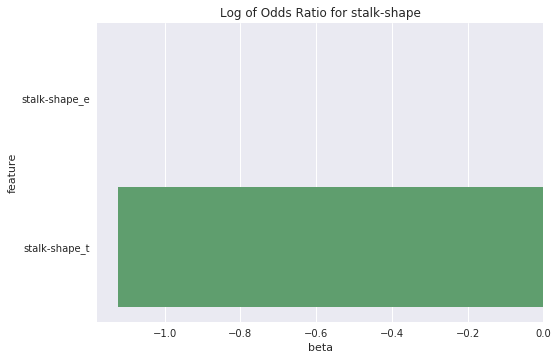

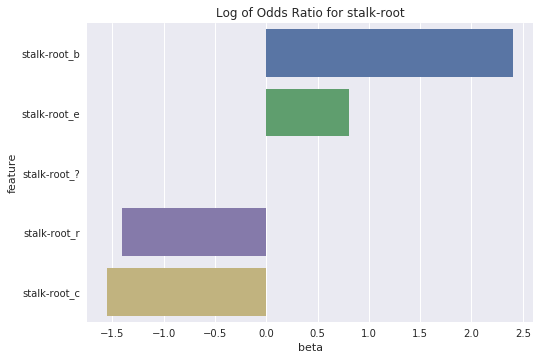

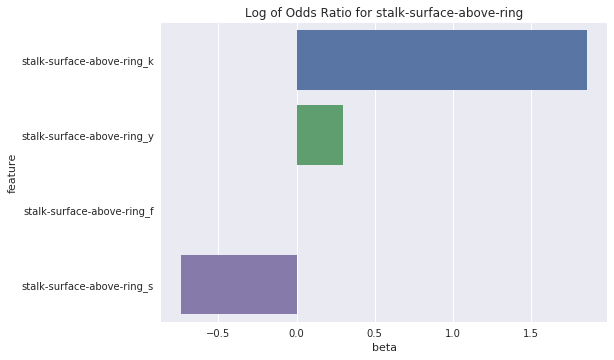

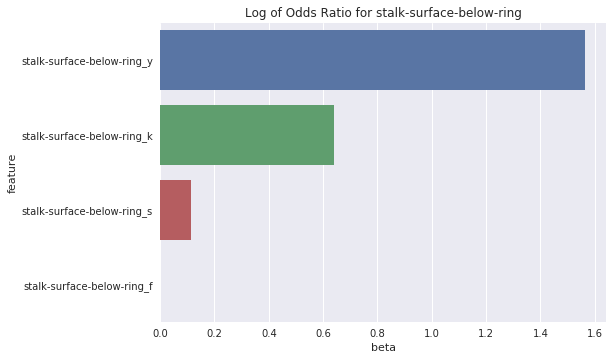

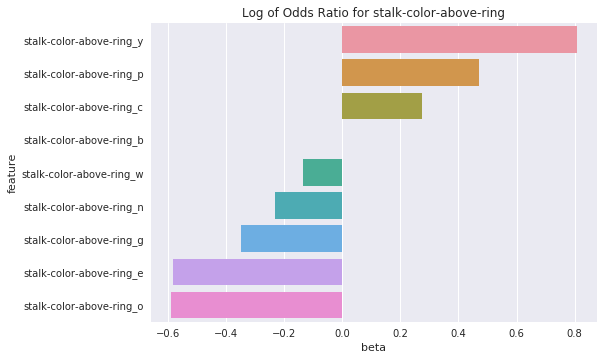

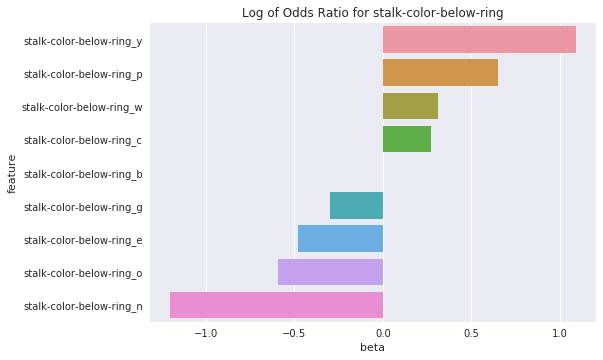

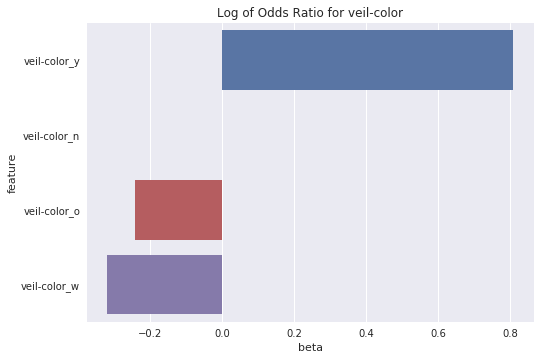

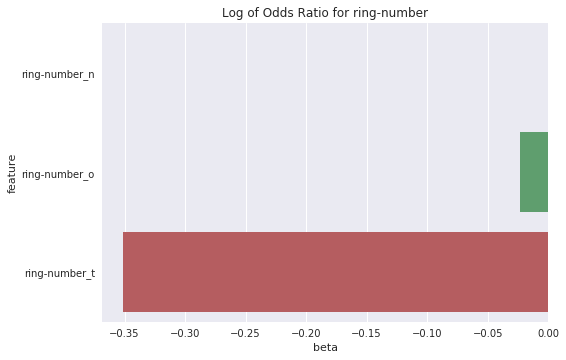

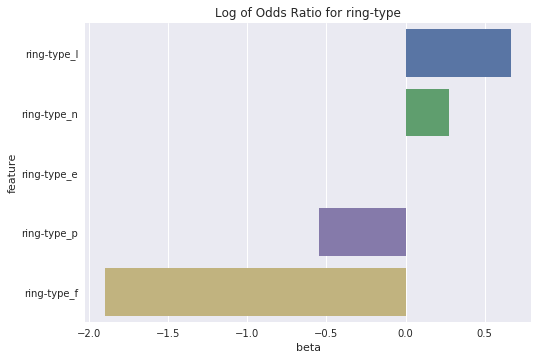

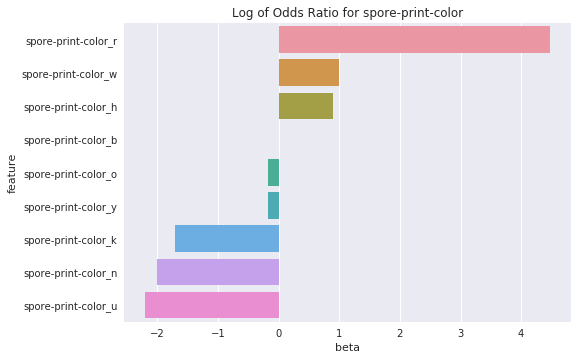

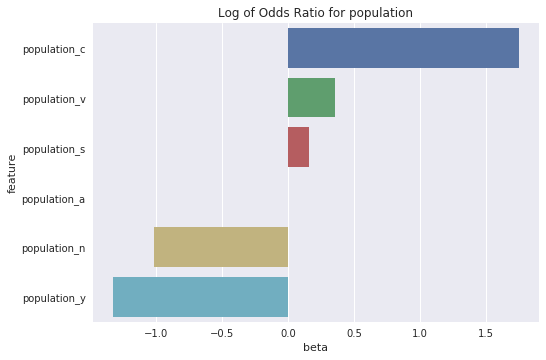

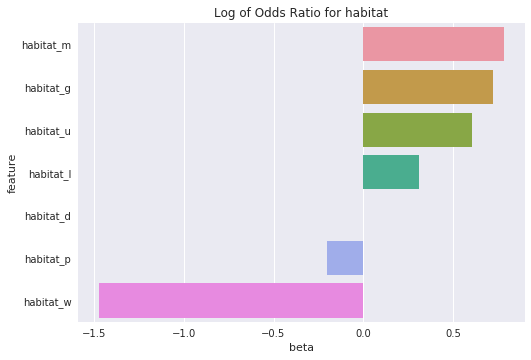

In [24]:
for feature in features:
    graph_ors(feature)

And that is it! 

Thanks again for checking this out and feel free to leave any comments!